In [54]:
import numpy as np
import random
import matplotlib.pyplot as plt 
%matplotlib notebook
%matplotlib inline 

In [55]:
from collections import namedtuple
import numpy.random as rd
import tensorflow.compat.v1 as tf
from tensorflow.python.ops.variables import Variable

import os
import warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
warnings.filterwarnings("ignore",category=FutureWarning)
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False
tf.disable_v2_behavior()

In [73]:
def plotNeuronProperty(name, neuron_param, ALIF, time_step, printSpikeTime=0):
    mse_error = 0
    peak_error = 0
    voltageList, currentList = [], []
                                                                                         
    n_batch = 1       
    n_in = 1
    noSpike_error = 100
    mse_scale = 10
    
    n_in, n_rec, n_out = 1, 1, 1 
    
    inW=np.ones([n_in, n_rec]) 
    inBias=np.zeros([n_in, n_rec])
    recW=np.zeros([n_rec, n_rec])
    outW = np.zeros([n_rec, n_out])
    
    synapse_param = [100, 100, inW, inBias, recW, outW]
    network_param = [n_in, n_rec, n_out]
    cell = ALIF(network_param, neuron_param, synapse_param)      
    
    # run simulation
    inputs = tf.placeholder(tf.float32, [n_batch, time_step, n_in], name='inputs')
    init_state = cell.zero_state(n_batch, tf.float32)
    rnn_out, states = tf.nn.dynamic_rnn(cell, inputs, initial_state=init_state)
    session = tf.Session()
    session.run(tf.global_variables_initializer())  
    for current in range(25, 300, 25): #current range, from 25pA to 300pA  
        
        sample = np.zeros(time_step)
        sample[50:time_step-50] = [current]*(time_step-100)
        in_current = np.reshape(sample, (n_batch, time_step, n_in) )
        out = session.run([rnn_out], feed_dict={inputs: in_current})
        out = np.array(out[0])   # [u, s, w, I1, I2, out], n_in, timestep, neuron

        voltageList.append(out[0][0].T[0])
        currentList.append(current)
    
    # readin experimental data
    targetList = np.loadtxt(input_file)
    targetList = targetList.reshape(11, -1)
    targetList = targetList[:,::10]  #match sampling rate                                                                                        
    voltageList = np.array(voltageList).reshape(11,-1)
    currentList = np.array(currentList).reshape(11,-1)
    targetList = np.concatenate((targetList, np.ones((11,time_step-200))*(-60)), axis=1)

    # calculate error
    for i in range(11,12):
        peak_p = find_peaks(voltageList[i-1], height=peak_high)[0]
        peak_t = find_peaks(targetList[i-1], height=peak_high)[0]
        length = min(len(peak_p), len(peak_t)) #number of spikes
        diff = peak_p[:length]-peak_t[:length]
        diff = np.append(diff, [noSpike_error]*(max(len(peak_p), len(peak_t))-length)) #error
        weight = np.arange(1, 10)[::-1]
        weight[2:]=1
        if len(weight)>len(diff):
                weight = weight[:len(diff)] 
        else:
                weight = np.append(weight, [1]*(len(diff)-len(weight)))
                                                                                        
        if len(diff):
            peak_error += sum(map(abs,diff*weight))

        if i<nonspike_fig:
            mse_error+=((voltageList[i-1] - targetList[i-1])**2).mean(axis=0)*mse_scale

        #plot
        plt.plot(np.arange(time_step), voltageList[i-1], label='computer\nsimulation')
        plt.plot(np.arange(time_step), targetList[i-1], label='biological\nexperiment')
        
        if i>nonspike_fig and printSpikeTime:
            #plt.text(0, 15, '_'.join(name.split('_')[1:]), size=12, color='blue')
            #plt.text(0, 0, '\npError: %d' % peak_error, size=11)
            plt.text(0, -25, 'simPlist:\n'+str(peak_t), size=11)
            plt.text(0, -50, 'bioPlist:\n'+str(peak_p), size=11)
        
        s_value=out[1][0].T[0]*50
        x_value=np.arange(len(s_value))
        plt.scatter(x_value, out[1][0].T[0]*25, s=s_value, c='red', marker='o')   
        plt.legend(loc = 1, fontsize='large')
    

In [74]:
############################################################################################
# neruon parameters fitted with biological experiments
############################################################################################
def getParam_singleFit(neuronType):
    if neuronType=='AdEx':
        from neuron_model.AdEx import ALIF
        param = param = {'Vahp': -23.5, 'Vth': -23.5, 'Vmax': 27.0, 't_ref': 6.0, 'R': 0.4, 'tau_m': 28.0, 'R_adp': 0.8, 'tau_w': 38.0, 'a': 70.0, 'delT': 1.5}
        neuron_param1 = [-58.4, param['Vth'], param['Vahp'], param['Vmax']] #Vrest, Vth, Vaph, Vmax 
        neuron_param2 = [param['t_ref'], param['R'], param['tau_m']]  #t_ref, R, tua_m
        neuron_param3 = [param['R_adp'], param['tau_w'], param['a']]     #R_adp, tau_w, a 
        neuron_param4 = [param['delT'],0,0,0,0] #delT, p, q, r, s   
    elif neuronType=='ALIF': 
        from neuron_model.ALIF import ALIF
        param = {'Vahp': -43.5, 'Vth': -41.0, 'Vmax': 18.5, 't_ref': 8.0, 'R': 0.3, 'tau_m': 62.5, 'R_adp': 0.9, 'tau_w': 57.5, 'a': 42.5}
        neuron_param1 = [-58.4, param['Vth'], param['Vahp'], param['Vmax']]  #Vrest, Vth, Vaph, Vmax 
        neuron_param2 = [param['t_ref'], param['R'], param['tau_m']] #t_ref, R, tua_m
        neuron_param3 = [param['R_adp'], param['tau_w'], param['a']]   #R_adp, tau_w, a 
        neuron_param4 = [0,0,0,0,0] #delT, p, q, r, s              
    elif neuronType=='LIF': 
        from neuron_model.LIF import ALIF
        param = {'Vahp': -30.5, 'Vth': -23.5, 'Vmax': 12.0, 't_ref': 17.5, 'R': 0.6, 'tau_m': 60.0}
        neuron_param1 = [-58.4, param['Vth'], param['Vahp'], param['Vmax']]  #Vrest, Vth, Vaph, Vmax 
        neuron_param2 = [param['t_ref'], param['R'], param['tau_m']] #t_ref, R, tua_m
        neuron_param3 = [0,0,0]   #R_adp, tau_w, a 
        neuron_param4 = [0,0,0,0,0] #delT, p, q, r, s   
    else:
        print("wrong neuron model name")
        exit(0)
    
    parameter=neuron_param1+neuron_param2+neuron_param3+neuron_param4
    
    return parameter, ALIF

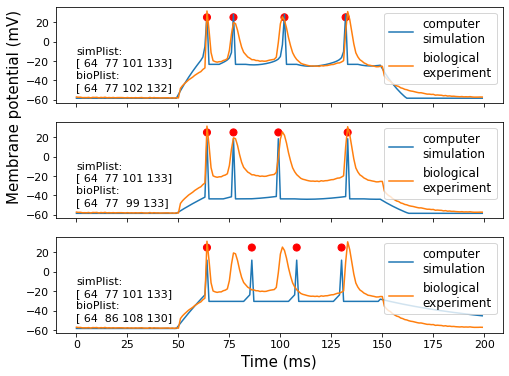

In [75]:
from scipy.signal import find_peaks
input_file = 'data_ex.txt' #experiment data 
peak_high = 0 #used to recognize spike for experiment curves 
nonspike_fig = 3 #number of curves that do not have spikes

fig = plt.figure(figsize=(8, 6))

n=1 
for name in ['AdEx','ALIF', 'LIF']:   
    h1=plt.subplot(3,1,n)
    neuron_param, ALIF = getParam_singleFit(name)
    plotNeuronProperty(name, neuron_param, ALIF, 200, printSpikeTime=1)    
    n+=1

    if n<=3:
        plt.setp(h1.get_xticklabels(), visible=False)

    plt.yticks(np.arange(-60, 40, 20), size=11)    
plt.xlabel('Time (ms)',fontdict={'size': 15})
fig.text(0.04, 0.65, "Membrane potential (mV)", rotation="vertical", va="center", size=15)
plt.xticks(size=11)
#plt.title("Fitting result for different model")
plt.show()

In [79]:
############################################################################################
# neruon parameters optimized for the delay experiments
############################################################################################
def getParam_optimized(neuronType):

    if neuronType=='ALIF_10': 
        from neuron_model.ALIF import ALIF
        param = {'Vahp': -58.5, 'Vth': -41.0, 'Vmax': 20.5, 't_ref': 1.0, 'R': 0.6, 'tau_m': 351.5, 'R_adp': 0.6, 'tau_w': 64.0, 'a': 51.5, 'rate_low': 10.5, 'rate_high': 47.5}
        neuron_param1 = [-58.4, param['Vth'], param['Vahp'], param['Vmax']]  #Vrest, Vth, Vaph, Vmax 
        neuron_param2 = [param['t_ref'], param['R'], param['tau_m']] #t_ref, R, tua_m
        neuron_param3 = [param['R_adp'], param['tau_w'], param['a']]   #R_adp, tau_w, a 
        neuron_param4 = [0,0,0,0,0] #delT, p, q, r, s      
    elif neuronType=='ALIF_5': 
        from neuron_model.ALIF import ALIF
        param = {'Vahp': -45.5, 'Vth': -35.5, 'Vmax': 31.0, 't_ref': 1.5, 'R': 0.3, 'tau_m': 425.0, 'R_adp': 0.8, 'tau_w': 430.5, 'a': 1.5, 'rate_low': 15.5, 'rate_high': 32.5}
        neuron_param1 = [-58.4, param['Vth'], param['Vahp'], param['Vmax']]  #Vrest, Vth, Vaph, Vmax 
        neuron_param2 = [param['t_ref'], param['R'], param['tau_m']] #t_ref, R, tua_m
        neuron_param3 = [param['R_adp'], param['tau_w'], param['a']]   #R_adp, tau_w, a 
        neuron_param4 = [0,0,0,0,0] #delT, p, q, r, s   
    elif neuronType=='ALIF_3': 
        from neuron_model.ALIF import ALIF
        param = {'Vahp': -43.5, 'Vth': -21.5, 'Vmax': 18.0, 't_ref': 3.0, 'R': 0.1, 'tau_m': 85.0, 'R_adp': 0.1, 'tau_w': 19.0, 'a': 379.0, 'rate_low': 41.5, 'rate_high': 44.0}
        neuron_param1 = [-58.4, param['Vth'], param['Vahp'], param['Vmax']]  #Vrest, Vth, Vaph, Vmax 
        neuron_param2 = [param['t_ref'], param['R'], param['tau_m']] #t_ref, R, tua_m
        neuron_param3 = [param['R_adp'], param['tau_w'], param['a']]   #R_adp, tau_w, a 
        neuron_param4 = [0,0,0,0,0] #delT, p, q, r, s  
    elif neuronType=='LIF_10': 
        from neuron_model.LIF import ALIF
        param = {'Vahp': -58.0, 'Vth': -54.0, 'Vmax': 37.5, 't_ref': 0.5, 'R': 0.4, 'tau_m': 288.5, 'rate_low': 7.5, 'rate_high': 27.0}
        neuron_param1 = [-58.4, param['Vth'], param['Vahp'], param['Vmax']]  #Vrest, Vth, Vaph, Vmax 
        neuron_param2 = [param['t_ref'], param['R'], param['tau_m']] #t_ref, R, tua_m
        neuron_param3 = [0,0,0]   #R_adp, tau_w, a 
        neuron_param4 = [0,0,0,0,0] #delT, p, q, r, s 
    elif neuronType=='LIF_5': 
        from neuron_model.LIF import ALIF
        param = {'Vahp': -43.5, 'Vth': -34.5, 'Vmax': 21.5, 't_ref': 1.5, 'R': 0.2, 'tau_m': 377.0, 'rate_low': 16.5, 'rate_high': 46.0}
        neuron_param1 = [-58.4, param['Vth'], param['Vahp'], param['Vmax']]  #Vrest, Vth, Vaph, Vmax 
        neuron_param2 = [param['t_ref'], param['R'], param['tau_m']] #t_ref, R, tua_m
        neuron_param3 = [0,0,0]   #R_adp, tau_w, a 
        neuron_param4 = [0,0,0,0,0] #delT, p, q, r, s 
    elif neuronType=='LIF_3': 
        from neuron_model.LIF import ALIF
        param = {'Vahp': -57.5, 'Vth': -35.5, 'Vmax': 23.5, 't_ref': 6.0, 'R': 0.3, 'tau_m': 295.0, 'rate_low': 16.5, 'rate_high': 43.0}
        neuron_param1 = [-58.4, param['Vth'], param['Vahp'], param['Vmax']]  #Vrest, Vth, Vaph, Vmax 
        neuron_param2 = [param['t_ref'], param['R'], param['tau_m']] #t_ref, R, tua_m
        neuron_param3 = [0,0,0]   #R_adp, tau_w, a 
        neuron_param4 = [0,0,0,0,0] #delT, p, q, r, s 
    else:
        print("wrong neuron model name")
        exit(0)
        
    parameter=neuron_param1+neuron_param2+neuron_param3+neuron_param4
    
    return parameter, ALIF

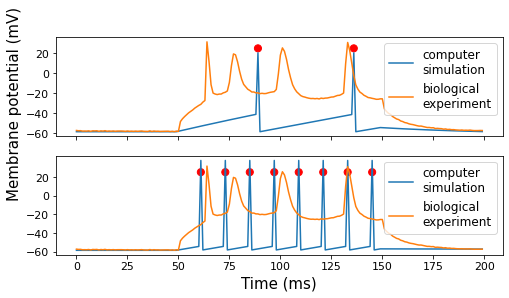

In [84]:
from scipy.signal import find_peaks
input_file = 'data_ex.txt' #experiment data 
peak_high = 0 #used to recognize spike for experiment curves 
nonspike_fig = 3 #number of curves that do not have spikes

fig = plt.figure(figsize=(8, 4))

n=1 
for name in ['ALIF_10','LIF_10']:   
    h1=plt.subplot(2,1,n)
    neuron_param, ALIF = getParam_optimized(name)
    plotNeuronProperty(name, neuron_param, ALIF, 200)    
    n+=1

    if n<=2:
        plt.setp(h1.get_xticklabels(), visible=False)

    plt.yticks(np.arange(-60, 40, 20), size=11)    
plt.xlabel('Time (ms)',fontdict={'size': 15})
fig.text(0.04, 0.65, "Membrane potential (mV)", rotation="vertical", va="center", size=15)
plt.xticks(size=11)
#plt.title("Fitting result for different model")
plt.show()